<h2> Redes Neurais e Aprendizado Profundo <h2>

- Camada Residual estilo ResNet (Residual Networks)
  - ResNet com Bloco de Identidade
  - ResNet com blocos Convolucionais para Redimensionamento


## Parte 0 - Bibliotecas e Dataset

In [ ]:
import time
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms

In [ ]:
#Padronizando sememente aleatória
torch.manual_seed(123)

#Device
device = torch.device('cuda') if torch.cuda.is_available else torch.device('cpu')
device

#Transformando dados para o tensor
transform = transforms.ToTensor()

#Conjunto de treinamento MNIST
train = datasets.MNIST(root = '.', train = True, download = True, transform=transform)
train_loader = torch.utils.data.DataLoader(train, batch_size=128, shuffle=True)

#Conjunto de teste MNIST
test = datasets.MNIST(root = '.', train = False, download = True, transform=transform)
test_loader = torch.utils.data.DataLoader(test, batch_size=128, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 67123314.67it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 161514258.43it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:06<00:00, 265680.65it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 29859762.96it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



## Parte 1 - ResNet com Bloco de Identidade



O bloco de `Identidade` é o padrão utilizado nas `Redes Residuais (ResNets)` e correspondem ao caso em que a ativação de entrada tem a mesma dimensão da ativação de saída. Abaixo é ilustrado o bloco de Identidade:

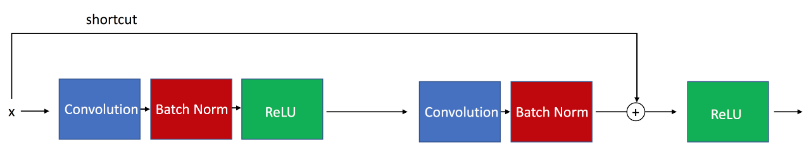

O caminho superior é o `caminho do atalho (shortcut)`. O caminho inferior é o "caminho principal".


In [ ]:
#Arquitetura com dois blocos residuais
class ConvIdentityBlocks(torch.nn.Module):

  def __init__(self, num_classes):
    super(ConvIdentityBlocks, self).__init__()


    #Primeiro bloco residual
    self.block1 = nn.Sequential(
                  nn.Conv2d(in_channels=1, out_channels=4,
                            kernel_size=(1,1), stride=(1,1),
                            padding=0),

                  nn.BatchNorm2d(4),

                  nn.ReLU(inplace=True),

                  nn.Conv2d(in_channels=4, out_channels=1,
                            kernel_size=(3,3), stride=(1,1),
                            padding=1),

                  nn.BatchNorm2d(1)
                  )

    #Segundo bloco residual
    self.block2 = nn.Sequential(
                  nn.Conv2d(in_channels=1, out_channels=4,
                            kernel_size=(1,1), stride=(1,1),
                            padding=0),

                  nn.BatchNorm2d(4),

                  nn.ReLU(inplace=True),

                  nn.Conv2d(in_channels=4, out_channels=1,
                            kernel_size=(3,3), stride=(1,1),
                            padding=1),

                  nn.BatchNorm2d(1)
                  )

    #Camada totalmente conectada
    self.linear1 = nn.Linear(1*28*28, num_classes)


  def forward(self, x):

    #Salvando minha entrada inicial no atalho
    shortcut = x

    #Passando a entrada para o primeiro bloco
    x = self.block1(x)
    x = F.relu(x + shortcut)

    #print('x for 1st block: ',x.size())

    #Salvando a entrada do bloco anterior no atalho
    shortcut = x
    #print('identity for 2sd block: ',x.size())

    #Passando a entrada para o segundo bloco
    x = self.block2(x)
    x = F.relu(x + shortcut)

    #print(x.size())
    output = self.linear1(x.view(-1,  1*28*28))

    return output

In [ ]:
#Alguns parâmetros
#Número de classes de acordo com o dataset MNIST
num_classes = 10
learning_rate = 0.001

#Instanciando a nossa classe de bloco de Indentidade
net_identity = ConvIdentityBlocks(num_classes=num_classes)

#Função de custo/perda
criterion = nn.CrossEntropyLoss()

#Optimizador
optimizer = optim.Adam(net_identity.parameters(), lr = learning_rate)

In [ ]:
#Visualizando as camadas da nossa rede com o bloco de Indentidade
net_identity.to(device)

ConvIdentityBlocks(
  (block1): Sequential(
    (0): Conv2d(1, 4, kernel_size=(1, 1), stride=(1, 1))
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(4, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (block2): Sequential(
    (0): Conv2d(1, 4, kernel_size=(1, 1), stride=(1, 1))
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(4, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (linear1): Linear(in_features=784, out_features=10, bias=True)
)

In [ ]:
#Visualizando os parâmetros
for name, param in net_identity.named_parameters():
  print(name, param.shape)

block1.0.weight torch.Size([4, 1, 1, 1])
block1.0.bias torch.Size([4])
block1.1.weight torch.Size([4])
block1.1.bias torch.Size([4])
block1.3.weight torch.Size([1, 4, 3, 3])
block1.3.bias torch.Size([1])
block1.4.weight torch.Size([1])
block1.4.bias torch.Size([1])
block2.0.weight torch.Size([4, 1, 1, 1])
block2.0.bias torch.Size([4])
block2.1.weight torch.Size([4])
block2.1.bias torch.Size([4])
block2.3.weight torch.Size([1, 4, 3, 3])
block2.3.bias torch.Size([1])
block2.4.weight torch.Size([1])
block2.4.bias torch.Size([1])
linear1.weight torch.Size([10, 784])
linear1.bias torch.Size([10])


In [ ]:
#Função para calcular a acurária da rede
def model_accuracy(model, data_loader):

  correct_pred = 0
  num_examples = 0

  for i, (inputs, labels) in enumerate(data_loader):

    inputs, labels = inputs.to(device), labels.to(device)
    logits = model(inputs)
    _, predicted_labels = torch.max(logits, 1)
    num_examples += labels.size(0)
    correct_pred += (predicted_labels == labels).sum()


  return correct_pred.float()/num_examples*100



#Número de épocas para o treinamento da rede
#num_epochs = 10

#Função para o calculo de tempo
start_time = time.time()
for epoch in range(num_epochs):

    #Instanciando o modelo para o modo treinamento
    model = net_identity.train()

    for batch_idx, (features, targets) in enumerate(train_loader):

        #Transferindo as imagens e labels para a GPU
        features = features.to(device)
        targets = targets.to(device)

        # FORWARD AND BACK PROP
        logits = model(features) #
        loss = criterion(logits, targets) #Calculo da função de perda
        optimizer.zero_grad()

        loss.backward()

        #Atualizando os parâmetros da rede
        optimizer.step()

        #Log de treinamento
        if not batch_idx % 250:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Loss: %.4f'
                   %(epoch+1, num_epochs, batch_idx,
                     len(train_loader), loss))


    #Modo de avalição da rede
    model = model.eval()
    with torch.set_grad_enabled(False):
        print('Época: %03d/%03d acurácia de treinamento: %.2f%%' % (epoch+1, num_epochs,
                                                              model_accuracy(model, train_loader)))
    #Tempo de treinamento de cada epoch
    print('Tempo de treino da epoch %03d: %.2f min\n' % (epoch+1, (time.time() - start_time)/60))

#Tempo total
print('\nTempo de treino total:: %.2f min' % ((time.time() - start_time)/60))

#Avaliação com o conjunto de teste
print('\nAcurácia do modelo no conjunto de teste: %.2f%%' % (model_accuracy(model, test_loader)))

Epoch: 001/010 | Batch 000/469 | Loss: 0.1982
Epoch: 001/010 | Batch 250/469 | Loss: 0.2761
Época: 001/010 acurácia de treinamento: 94.16%
Tempo de treino da epoch 001: 0.14 min

Epoch: 002/010 | Batch 000/469 | Loss: 0.2644
Epoch: 002/010 | Batch 250/469 | Loss: 0.1949
Época: 002/010 acurácia de treinamento: 94.22%
Tempo de treino da epoch 002: 0.28 min

Epoch: 003/010 | Batch 000/469 | Loss: 0.1218
Epoch: 003/010 | Batch 250/469 | Loss: 0.1846
Época: 003/010 acurácia de treinamento: 94.22%
Tempo de treino da epoch 003: 0.43 min

Epoch: 004/010 | Batch 000/469 | Loss: 0.1967
Epoch: 004/010 | Batch 250/469 | Loss: 0.2151
Época: 004/010 acurácia de treinamento: 94.11%
Tempo de treino da epoch 004: 0.57 min

Epoch: 005/010 | Batch 000/469 | Loss: 0.1909
Epoch: 005/010 | Batch 250/469 | Loss: 0.1138
Época: 005/010 acurácia de treinamento: 94.09%
Tempo de treino da epoch 005: 0.71 min

Epoch: 006/010 | Batch 000/469 | Loss: 0.1456
Epoch: 006/010 | Batch 250/469 | Loss: 0.2509
Época: 006/01

## Parte 2 - ResNet com blocos Convolucionais para Redimensionamento

Implementação dos `blocos residuais com conexões de salto`, de modo que a entrada passada pelo atalho corresponda às dimensões da saída do caminho principal. O `bloco convolucional` do ResNet é o outro tipo de bloco. Você pode utilizar este tipo de bloco quando as dimensões de entrada e saída não correspondem.

A diferença com o bloco de identidade é que há uma camada de `Conv2d` no caminho de atalho.

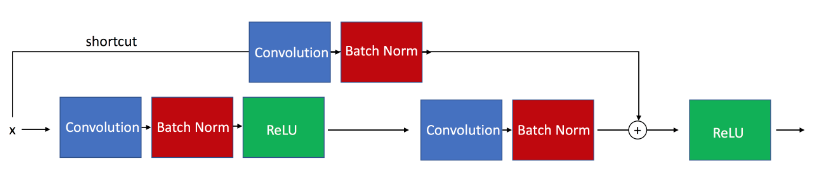

A camada `Conv2d` no caminho de atalho é usada para redimensionar a entrada 'x' para uma dimensão diferente, de modo que as dimensões do bloco coincidam na adição final necessária para adicionar (somar) o valor de atalho ao caminho/arquitetura principal.




Por exemplo para reduzir a altura e a largura das dimensões de ativação por um fator de 2, você pode usar uma `Conv2d` de dimensão `1x1` com o stride/passo de 2. A camada de Conv2d no caminho de atalho não utiliza nenhuma função de ativação linear. Sua função principal é apenas aplicar uma função linear (aprendida) que reduz a dimensão de entrada, de modo que as dimensões correspondam à etapa de adição posterior.

In [ ]:
class ResidualBlock(nn.Module):

    def __init__(self, channels):
        super(ResidualBlock, self).__init__()

        self.block = nn.Sequential(
                     nn.Conv2d(in_channels=channels[0],
                                out_channels=channels[1],
                                kernel_size=(3, 3),
                                stride=(2, 2),
                                padding=1),
                     nn.BatchNorm2d(channels[1]),
                     nn.ReLU(inplace=True),
                     nn.Conv2d(in_channels=channels[1],
                                out_channels=channels[2],
                                kernel_size=(1, 1),
                                stride=(1, 1),
                                padding=0),
                     nn.BatchNorm2d(channels[2])
        )

        self.shortcut = nn.Sequential(
                        nn.Conv2d(in_channels=channels[0],
                                    out_channels=channels[2],
                                    kernel_size=(1, 1),
                                    stride=(2, 2),
                                    padding=0),
                        nn.BatchNorm2d(channels[2])
        )


    def forward(self, x):

        shortcut = x

        block = self.block(x)
        shortcut = self.shortcut(x)

        x = nn.functional.relu(block+shortcut) #outra maneira de utilizar a função relu

        return x

In [ ]:
#Definindo a estrutura de uma rede convolucional simples
class ConvNet(nn.Module):

    def __init__(self, num_classes):
        super(ConvNet, self).__init__()

        self.residual_block1 = ResidualBlock(channels=[1, 4, 8])

        self.residual_block2 = ResidualBlock(channels=[8, 16, 32])

        self.linear1 = nn.Linear(7*7*32, num_classes)


    def forward(self, x):

        out = self.residual_block1(x)
        out = self.residual_block2(out)

        out = self.linear1(out.view(-1, 7*7*32))

        return out

In [ ]:
#Número de classes de acordo com o dataset MNIST
num_classes = 10

#Instanciando a nossa classe de bloco de Indentidade
net_conv_residual = ConvNet(num_classes=num_classes)

#Função de custo/perda
criterion = nn.CrossEntropyLoss()

#Optimizador
optimizer = optim.Adam(net_conv_residual.parameters())

In [ ]:
#Visualizando as camadas da nossa rede com o bloco de Indentidade
net_conv_residual.to(device)

ConvNet(
  (residual_block1): ResidualBlock(
    (block): Sequential(
      (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(4, 8, kernel_size=(1, 1), stride=(1, 1))
      (4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (shortcut): Sequential(
      (0): Conv2d(1, 8, kernel_size=(1, 1), stride=(2, 2))
      (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (residual_block2): ResidualBlock(
    (block): Sequential(
      (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(16, 32, kernel_size=(1, 1), stride=(1, 1))
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_run

In [ ]:
#Visualizando os parâmetros
for name, param in net_conv_residual.named_parameters():
  print(name, param.shape)

residual_block1.block.0.weight torch.Size([4, 1, 3, 3])
residual_block1.block.0.bias torch.Size([4])
residual_block1.block.1.weight torch.Size([4])
residual_block1.block.1.bias torch.Size([4])
residual_block1.block.3.weight torch.Size([8, 4, 1, 1])
residual_block1.block.3.bias torch.Size([8])
residual_block1.block.4.weight torch.Size([8])
residual_block1.block.4.bias torch.Size([8])
residual_block1.shortcut.0.weight torch.Size([8, 1, 1, 1])
residual_block1.shortcut.0.bias torch.Size([8])
residual_block1.shortcut.1.weight torch.Size([8])
residual_block1.shortcut.1.bias torch.Size([8])
residual_block2.block.0.weight torch.Size([16, 8, 3, 3])
residual_block2.block.0.bias torch.Size([16])
residual_block2.block.1.weight torch.Size([16])
residual_block2.block.1.bias torch.Size([16])
residual_block2.block.3.weight torch.Size([32, 16, 1, 1])
residual_block2.block.3.bias torch.Size([32])
residual_block2.block.4.weight torch.Size([32])
residual_block2.block.4.bias torch.Size([32])
residual_block

In [ ]:
#Função para calcular a acurária da rede
def model_accuracy(model, data_loader):

  correct_pred = 0
  num_examples = 0

  for i, (inputs, labels) in enumerate(data_loader):

    inputs, labels = inputs.to(device), labels.to(device)
    logits = model(inputs)
    _, predicted_labels = torch.max(logits, 1)
    num_examples += labels.size(0)
    correct_pred += (predicted_labels == labels).sum()


  return correct_pred.float()/num_examples*100



#Número de épocas para o treinamento da rede
#num_epochs = 10

#Função para o calculo de tempo
start_time = time.time()
for epoch in range(num_epochs):

    #Instanciando o modelo para o modo treinamento
    model = net_identity.train()

    for batch_idx, (features, targets) in enumerate(train_loader):

        #Transferindo as imagens e labels para a GPU
        features = features.to(device)
        targets = targets.to(device)

        # FORWARD AND BACK PROP
        logits = model(features) #
        loss = criterion(logits, targets) #Calculo da função de perda
        optimizer.zero_grad()

        loss.backward()

        #Atualizando os parâmetros da rede
        optimizer.step()

        #Log de treinamento
        if not batch_idx % 250:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Loss: %.4f'
                   %(epoch+1, num_epochs, batch_idx,
                     len(train_loader), loss))


    #Modo de avalição da rede
    model = model.eval()
    with torch.set_grad_enabled(False):
        print('Época: %03d/%03d acurácia de treinamento: %.2f%%' % (epoch+1, num_epochs,
                                                              model_accuracy(model, train_loader)))
    #Tempo de treinamento de cada epoch
    print('Tempo de treino da epoch %03d: %.2f min\n' % (epoch+1, (time.time() - start_time)/60))

#Tempo total
print('\nTempo de treino total:: %.2f min' % ((time.time() - start_time)/60))

#Avaliação com o conjunto de teste
print('\nAcurácia do modelo no conjunto de teste: %.2f%%' % (model_accuracy(model, test_loader)))

Epoch: 001/010 | Batch 000/469 | Loss: 0.2226
Epoch: 001/010 | Batch 250/469 | Loss: 0.2341
Época: 001/010 acurácia de treinamento: 94.44%
Tempo de treino da epoch 001: 0.14 min

Epoch: 002/010 | Batch 000/469 | Loss: 0.1577
Epoch: 002/010 | Batch 250/469 | Loss: 0.2072
Época: 002/010 acurácia de treinamento: 94.44%
Tempo de treino da epoch 002: 0.28 min

Epoch: 003/010 | Batch 000/469 | Loss: 0.2218
Epoch: 003/010 | Batch 250/469 | Loss: 0.2950
Época: 003/010 acurácia de treinamento: 94.44%
Tempo de treino da epoch 003: 0.42 min

Epoch: 004/010 | Batch 000/469 | Loss: 0.1733
Epoch: 004/010 | Batch 250/469 | Loss: 0.2684
Época: 004/010 acurácia de treinamento: 94.44%
Tempo de treino da epoch 004: 0.56 min

Epoch: 005/010 | Batch 000/469 | Loss: 0.1701
Epoch: 005/010 | Batch 250/469 | Loss: 0.1284
Época: 005/010 acurácia de treinamento: 94.43%
Tempo de treino da epoch 005: 0.70 min

Epoch: 006/010 | Batch 000/469 | Loss: 0.1570
Epoch: 006/010 | Batch 250/469 | Loss: 0.1567
Época: 006/01

## Referências
- **CNN 2.2 - Introduction to Residual Networks:** https://www.kaggle.com/code/patthoo/cnn-2-2-introduction-to-residual-networks/notebook

- **stat453-deep-learning-ss21:** https://github.com/rasbt/stat453-deep-learning-ss21/blob/main/L14/2-resnet-example.ipynb